In [1]:
from functools import partial
import numpy as np
import pandas as pd
import pandera as pa
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from simpler_mpl import set_common_mpl_styles, set_commas

In [2]:
# Population
TRAIN_SIZE = 100_000
# ML
TEST_SIZE = 50_000  # 0.3 # 0.3 means 30% test set size

#SIZE = 500_000
#TEST_SIZE = 100_000 

BASE_CHURN = 0.16  # 16% churn means 84% retention

features = ["mkt_neg", "bad_exp", "mkt_pos", "brand_loyal"]


In [3]:
# rng.binomial(nbr events e.g. 1 means 0 or 1, p is probability of True, size is nbr of items to generate)

# a bad_exp means they had a problem (e.g. bad insurance claim, hard time with mobile phone tech support),
# this increases their likelihood of churn
# mkt_neg means they really don't like getting marketing and this will increase their likelihood of churn
# gets_mkting is a 50/50 split for Treatment (True) or Control (False)

def make_ppl(nbr_rows, base_churn, seed=0):
    rng = np.random.default_rng(seed=seed)
    ppl = pd.DataFrame(
        {
            "brand_loyal": rng.binomial(1, 0.25, nbr_rows),  # True if they just love to renew
            "bad_exp": rng.binomial(
                1, 0.25, nbr_rows
            ),  # True if they had a bad experience with company
            "mkt_neg": rng.binomial(
                1, 0.25, nbr_rows
            ),  # True if receiving marketing will increase churn probability for them
            "mkt_pos": rng.binomial(
                1, 0.25, nbr_rows
            ),  # True if marketing helps retain this customer
        }
    )
    #ppl["prob_churn"] = BASE_CHURN  # # a reasonably standard churn rate
    ppl["prob_churn"] = rng.uniform(base_churn - 0.02, base_churn + 0.02, nbr_rows)
    return ppl

In [4]:
def determine_churners(ppl, marketing_prop, seed=0):
        """People churn based the marketing_prop==[0.0, 1.0] who receive marketing, 
    1.0 means all get it, 0 means none, 0.5 means half"""
    ppl = ppl.copy()
    rng = np.random.default_rng(seed=0)
    nbr_rows = ppl.shape[0]
    assert marketing_prop >=0 and marketing_prop <= 1.0, "Must be [0, 1] as a proportion"
    ppl["gets_mkting"] = rng.binomial(1, marketing_prop, nbr_rows)
    # people who like marketing and who get marketing have a lower chance of churning
    mask_mkt_pos = (ppl["mkt_pos"] & ppl["gets_mkting"]) == 1  # trues are 1s (ints)
    ppl.loc[mask_mkt_pos, "prob_churn"] -= 0.1


    # people who hate marketing and who get marketing have a higher chance of churning
    mask_mkt_neg = (ppl["mkt_neg"] & ppl["gets_mkting"]) == 1  # trues are 1s (ints)
    ppl.loc[mask_mkt_neg, "prob_churn"] += 0.1  # TODO HUGE BIAS

    # people who have had a negative experience have a higher chance of churn
    mask_bad_exp = ppl["bad_exp"] == 1
    ppl.loc[mask_bad_exp, "prob_churn"] += 0.1

    # people who like the brand experience have a lower chance of churn
    mask_brand_loyal = ppl["brand_loyal"] == 1
    ppl.loc[mask_brand_loyal, "prob_churn"] -= 0.1

    ppl["prob_churn"] = ppl["prob_churn"].clip(lower=0, upper=1)
    ppl["will_churn"] = rng.binomial(1, ppl["prob_churn"], ppl.shape[0])
    return ppl

# TODO uplift_test should be 1.0, not 0.999
marketing_props = {'uplift_train': 0.5, 'uplift_test': 0.999, 'churn_train': 0.0, 'churn_test': 1.0}
model_type = 'uplift'
ppl_train = make_ppl(TRAIN_SIZE, BASE_CHURN)
#ppl_train = determine_churners(ppl_train, marketing_prop=0)
ppl_train = determine_churners(ppl_train, marketing_prop=marketing_props[f"{model_type}_train"])

ppl_test = make_ppl(TEST_SIZE, BASE_CHURN)
ppl_test = determine_churners(ppl_test, marketing_prop=marketing_props[f"{model_type}_test"])

X_train = ppl_train[features]
X_test = ppl_test[features]
y_train = ppl_train["will_churn"]
y_test = ppl_test["will_churn"]

ppl = pd.concat((ppl_train, ppl_test))
assert ppl.shape[1] == ppl_train.shape[1]
#ppl_train, ppl_test, X_train, X_test, y_train, y_test = train_test_split(
#    ppl, ppl[features], ppl["will_churn"], test_size=TEST_SIZE, shuffle=True
#)

ppl.sample(5) # sample from whole population

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
26209,0,0,0,0,0.146387,0,0
26534,0,0,0,0,0.151955,1,0
30960,1,0,0,0,0.040732,0,1
19201,0,0,0,1,0.068516,1,0
76704,0,0,0,0,0.175097,1,0


In [5]:
percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]
ppl_train.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.249160,0.248500,0.250310,0.252100,0.160717,0.500180,0.162680
std,0.432529,0.432145,0.433194,0.434221,0.074304,0.500002,0.369075
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000,0.046106,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.160005,1.000000,0.000000
95%,1.000000,1.000000,1.000000,1.000000,0.274027,1.000000,1.000000
99%,1.000000,1.000000,1.000000,1.000000,0.358998,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.379999,1.000000,1.000000


In [6]:
ppl_test.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000
mean,0.252420,0.249360,0.246240,0.25070,0.160728,0.999080,0.164620
std,0.434405,0.432647,0.430824,0.43342,0.084253,0.030318,0.370841
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1%,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
5%,0.000000,0.000000,0.000000,0.00000,0.042365,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.00000,0.159926,1.000000,0.000000
95%,1.000000,1.000000,1.000000,1.00000,0.277137,1.000000,1.000000
99%,1.000000,1.000000,1.000000,1.00000,0.368811,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.00000,0.379992,1.000000,1.000000


In [7]:
ppl.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.250247,0.248787,0.248953,0.251633,0.160721,0.666480,0.163327
std,0.433156,0.432311,0.432408,0.433953,0.077761,0.471472,0.369665
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000,0.044754,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.159981,1.000000,0.000000
95%,1.000000,1.000000,1.000000,1.000000,0.275219,1.000000,1.000000
99%,1.000000,1.000000,1.000000,1.000000,0.363574,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.379999,1.000000,1.000000


In [ ]:
# calc nbr and percentage ppl who churn given probability estimates
#ppl["prob_churn_bin"] = pd.cut(ppl["prob_churn"], bins=10)
#display(ppl.groupby("prob_churn_bin")["will_churn"].sum())
#display(
#    ppl.groupby("prob_churn_bin")["will_churn"].sum()
#    / ppl.groupby("prob_churn_bin")["will_churn"].size()
#)
#ppl = ppl.drop(columns="prob_churn_bin")

In [13]:
ppl

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
0,0,0,0,1,0.057282,1,0
1,0,0,0,1,0.064466,1,0
2,0,0,0,0,0.173355,0,0
3,0,1,1,0,0.248802,0,1
4,1,1,1,0,0.279528,1,0
...,...,...,...,...,...,...,...
49995,0,0,0,0,0.179378,1,1
49996,1,1,0,0,0.152152,1,0
49997,0,0,0,0,0.148298,1,0
49998,0,0,0,0,0.175527,1,0


In [14]:
# check that mkt_neg people have a greater prob_churn than non-mkt_neg ppl for a 2 sample ttest

# COULD DO
# prob_churn and will_churn should be reasonably similar (to 2dp?)

schema = pa.DataFrameSchema(
    {
        "bad_exp": pa.Column(int, pa.Check.isin([0, 1])),
        "brand_loyal": pa.Column(int, pa.Check.isin([0, 1])),
        "mkt_neg": pa.Column(int, pa.Check.isin([0, 1])),
        "mkt_pos": pa.Column(int, pa.Check.isin([0, 1])),
        # gets_mkting should be circa 50%
        "gets_mkting": pa.Column(
            int,
            [
                pa.Check.isin([0, 1]),
                # TODO should check no mkting for train, mkting for test
                #pa.Check(lambda s: s.mean() > 0.45),
                #pa.Check(lambda s: s.mean() < 0.55),
            ],
        ),
        "will_churn": pa.Column(int, pa.Check.isin([0, 1])),
        # prob_churn bounded [0, 1] and if mkt_neg is True then prob_churn should be greater than if mkt_neg if False
        "prob_churn": pa.Column(
            float,
            [
                pa.Check.le(1.0),
                pa.Check.ge(0),
                pa.Hypothesis.two_sample_ttest(
                    sample1=1,
                    sample2=0,
                    groupby="mkt_neg",
                    relationship="greater_than",
                    alpha=0.05,
                    equal_var=True,
                ),
            ],
        ),
    },
    strict=True,
    ordered=False,
)
schema.validate(
    ppl,
    lazy=True,
);

# Look at some examples of those who do or don't churn

In [15]:
ppl.query("will_churn==True and prob_churn > @BASE_CHURN")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
3,0,1,1,0,0.248802,0,1
21,0,1,1,1,0.253342,1,1


In [17]:
ppl.query("will_churn==False")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
0,0,0,0,1,0.057282,1,0
1,0,0,0,1,0.064466,1,0


# Start to prepare for ML

In [18]:
ppl.columns

Index(['brand_loyal', 'bad_exp', 'mkt_neg', 'mkt_pos', 'prob_churn',
       'gets_mkting', 'will_churn'],
      dtype='object')

In [19]:
assert len(set(features)) == len(features), "Not expecting duplicates"
print(f"Using: {features}")

# check we've not forgotten any columns as new features
non_features = (
    set(ppl.columns)
    .difference(set(features))
    .difference({"will_churn", "prob_churn", "gets_mkting"})
)

if len(non_features) > 0:
    print(f"IGNORING !!!!!!! {non_features}")
    1 / 0  # we shouldn't get here

Using: ['mkt_neg', 'bad_exp', 'mkt_pos', 'brand_loyal']


In [20]:
#ppl_train, ppl_test, X_train, X_test, y_train, y_test = train_test_split(
#    ppl, ppl[features], ppl["will_churn"], test_size=TEST_SIZE, shuffle=True
#)
print(list(x.shape for x in [ppl_train, ppl_test, X_train, X_test, y_train, y_test]))

[(100000, 7), (50000, 7), (100000, 4), (50000, 4), (100000,), (50000,)]


In [21]:
est_dummy = DummyClassifier(strategy="prior")
est_dummy.fit(X_train, y_train)

dummy_proba_pos = est_dummy.predict_proba(X_test)[:, 1]
log_loss(y_test, dummy_proba_pos)

0.44726586732773044

In [22]:
base_model = LogisticRegression
#base_model = partial(RandomForestClassifier, n_estimators=5)

In [ ]:
churn_model = base_model
# churn_model = LogisticRegression
# churn_model = partial(RandomForestClassifier, n_estimators=10)
est_churn = churn_model()
est_churn.fit(X_train, y_train)
print(f"Fitting churn model with {churn_model}")

y_pred = est_churn.predict_proba(X_test)
y_pred_proba_pos = y_pred[:, 1]
log_loss(y_test, y_pred_proba_pos)

## Start to prepare for dual fit

In [24]:
# TODO duplication here will hurt and will make debugging much
# harder, this needs simplifying!
# higher logloss is worse
uplift_model = base_model
# uplift_model = LogisticRegression
# uplift_model = partial(RandomForestClassifier, n_estimators=10)
est_up_c = uplift_model()
est_up_t = uplift_model()

print(f"Building a C and T model with {est_up_c} and {est_up_t}")

mask_train_c = ppl_train["gets_mkting"] == 0
mask_train_t = ppl_train["gets_mkting"] == 1

est_up_c.fit(X_train[mask_train_c], y_train[mask_train_c])
est_up_t.fit(X_train[mask_train_t], y_train[mask_train_t])

# score on their sub-trained population type
mask_test_c = ppl_test["gets_mkting"] == 0
mask_test_t = ppl_test["gets_mkting"] == 1
# if we have e.g. all-get-marketing then the control group has 0 size
if mask_test_c.sum() > 0:
    up_c_pred_proba_pos = est_up_c.predict_proba(X_test[mask_test_c])[:, 1]
    print(log_loss(y_test[mask_test_c], up_c_pred_proba_pos))
if mask_test_t.sum() > 0:
    up_t_pred_proba_pos = est_up_t.predict_proba(X_test[mask_test_t])[:, 1]
    print(
        log_loss(y_test[mask_test_t], up_t_pred_proba_pos)
    )  # CHECK expect lower than control

Building a C and T model with LogisticRegression() and LogisticRegression()
0.5063920462111962
0.4194220516641954


## Check C and T predictions from Uplift model

In [25]:
pd.Series(up_c_pred_proba_pos).describe()

count    46.000000
mean      0.169032
std       0.064012
min       0.072742
25%       0.156801
50%       0.156801
75%       0.159399
max       0.277682
dtype: float64

In [26]:
pd.Series(up_t_pred_proba_pos).describe()

count    49954.000000
mean         0.162025
std          0.085239
min          0.032939
25%          0.075896
50%          0.154305
75%          0.244530
max          0.418296
dtype: float64

# Gains chart

Note if T prob guessed more-wrong than C prob then it is possible for a decreasing gains line.

In [27]:
if False:
    # incorrect for uplift! # WRONG
    result = pd.DataFrame({"churn_proba_pos": y_pred_proba_pos, "y_true": y_test})
    result["dummy_proba_pos"] = est_dummy.predict_proba(X_test)[:, 1]

    result["uplift_proba_pos"] = -1
    result.loc[mask_test_t, "uplift_proba_pos"] = up_t_pred_proba_pos
    result.loc[mask_test_c, "uplift_proba_pos"] = up_c_pred_proba_pos
    assert (result["uplift_proba_pos"] == -1).sum() == 0, "No entries for -1 expected"

    fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
    fig.suptitle("Gains curve - Positive divergence\nmeans better ordering")
    keys = ["uplift_proba_pos", "churn_proba_pos", "dummy_proba_pos"]
    for key in keys:
        result_sorted = result.sort_values(key, ascending=False).reset_index()
        result_sorted["y_true_cum"] = result_sorted["y_true"].cumsum()
        result_sorted.plot(kind="line", y="y_true_cum", ax=ax, label=key)
    ax.set_ylabel("True Positives (faster climb better)")
    ax.set_xlabel("Test population")

    set_common_mpl_styles(ax, grid_axis="both")
    # set_commas(ax, True, True)

    # ax.set_xlim((10_000, result.shape[0]-1)); # zoom on x axis

In [28]:
# incorrect for uplift!
result = pd.DataFrame({"y_true": y_test})

result["churn_proba_pos"] = est_churn.predict_proba(X_test)[:, 1]
result["dummy_proba_pos"] = est_dummy.predict_proba(X_test)[:, 1]

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
fig.suptitle("Gains curve - Positive divergence\nmeans better ordering")
# key = 'uplift_diff_t_c'
#keys = ['churn_proba_pos', 'dummy_proba_pos']
keys = [#"churn_proba_pos",
    "uplift_diff_t_c",
    "up_proba_c",
    "up_proba_t",
    "dummy_proba_pos", 
]  # , 'churn_proba_pos']
for key in keys:
    linestyle = "-"
    linewidth = 2
    if key in {"up_proba_c", "up_proba_t"}:
        linestyle = "--"
        linewidth = 1
    result_sorted = result.sort_values(key, ascending=False).reset_index()
    result_sorted["y_true_cum"] = result_sorted["y_true"].cumsum()
    result_sorted.plot(
        kind="line",
        y="y_true_cum",
        ax=ax,
        label=key,
        linestyle=linestyle,
        linewidth=linewidth,
    )
ax.set_ylabel("True Positives (faster climb better)")
ax.set_xlabel("Test population")

set_common_mpl_styles(ax, grid_axis="both")
# set_commas(ax, True, True)

# # zoom on x axis
# ax.set_xlim((45_000, result.shape[0]-1));
# ax.set_ylim(ymin=6000);

NameError: name 'est_churn' is not defined

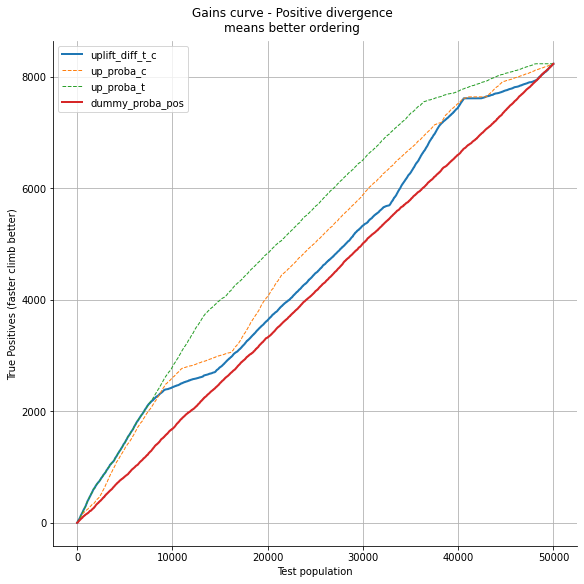

In [30]:
# incorrect for uplift!
result = pd.DataFrame({"y_true": y_test})

#result["churn_proba_pos"] = est_churn.predict_proba(X_test)[:, 1]
result["dummy_proba_pos"] = est_dummy.predict_proba(X_test)[:, 1]


result["up_proba_c"] = est_up_c.predict_proba(X_test)[:, 1]
result["up_proba_t"] = est_up_t.predict_proba(X_test)[:, 1]
# if T says 90% prob churn conditional mkting, C says 10% prob churn then +80%
# if T says 10% prob churn conditional mkting, C says 90% prob churn then -80%
result["uplift_diff_t_c"] = result["up_proba_t"] - result["up_proba_c"]

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
fig.suptitle("Gains curve - Positive divergence\nmeans better ordering")
# key = 'uplift_diff_t_c'
# keys = ['uplift_diff_t_c', 'churn_proba_pos', 'dummy_proba_pos']
keys = [#"churn_proba_pos",
    "uplift_diff_t_c",
    "up_proba_c",
    "up_proba_t",
    "dummy_proba_pos", 
]  # , 'churn_proba_pos']
for key in keys:
    linestyle = "-"
    linewidth = 2
    if key in {"up_proba_c", "up_proba_t"}:
        linestyle = "--"
        linewidth = 1
    result_sorted = result.sort_values(key, ascending=False).reset_index()
    result_sorted["y_true_cum"] = result_sorted["y_true"].cumsum()
    result_sorted.plot(
        kind="line",
        y="y_true_cum",
        ax=ax,
        label=key,
        linestyle=linestyle,
        linewidth=linewidth,
    )
ax.set_ylabel("True Positives (faster climb better)")
ax.set_xlabel("Test population")

set_common_mpl_styles(ax, grid_axis="both")
# set_commas(ax, True, True)

# # zoom on x axis
# ax.set_xlim((45_000, result.shape[0]-1));
# ax.set_ylim(ymin=6000);

<AxesSubplot:>

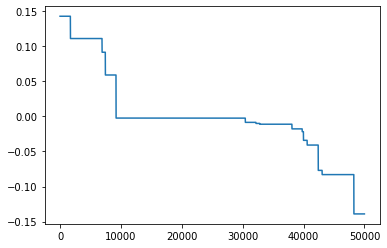

In [31]:
# sort by predicted uplift, the earliest values have lowest chance of churn if marketed at or are sure things,
# the last values have highest chance of churn if marketed at (sleeping dogs) or are lost causes
result.sort_values("uplift_diff_t_c", ascending=False)["uplift_diff_t_c"].reset_index(
    drop=True
).plot()

In [32]:
test_merged = pd.merge(
    left=result,
    right=ppl_test,
    left_index=True,
    right_index=True,
    validate="one_to_one",
)
assert test_merged.shape[0] == TEST_SIZE
test_merged.sample(10).sort_values("prob_churn").drop(
    columns=["dummy_proba_pos", "churn_proba_pos"]
)

KeyError: "['churn_proba_pos'] not found in axis"

In [33]:
test_merged["uplift_diff_t_c_bins"] = pd.cut(test_merged["uplift_diff_t_c"], 3)
#test_merged["churn_proba_pos_bins"] = pd.cut(test_merged["churn_proba_pos"], 3)

#test_merged['uplift_diff_t_c_bins'] = pd.qcut(test_merged['uplift_diff_t_c'], 4)
features

['mkt_neg', 'bad_exp', 'mkt_pos', 'brand_loyal']

In [34]:
res = test_merged.groupby("uplift_diff_t_c_bins").agg(
    count=pd.NamedAgg("mkt_neg", "size"),
    prob_churn_if_mktd=pd.NamedAgg("will_churn", "mean"),
    mkt_pos_sum=pd.NamedAgg("mkt_pos", "sum"),
    bad_exp_sum=pd.NamedAgg("bad_exp", "sum"),
    brand_loyal_sum=pd.NamedAgg("brand_loyal", "sum"),
    mkt_neg_sum=pd.NamedAgg("mkt_neg", "sum"),
    up_proba_c_mean=pd.NamedAgg("up_proba_c", "mean"),
    up_proba_t_mean=pd.NamedAgg("up_proba_t", "mean"),
)
#res

# For each row in the test set, group and explain the features

If we order the data by predicted use of marketing to increase lift, we can count the underlying features - these should reflect the original distributions.

* sure things - have `brand_loyal` and don't respond to marketing, they're likelier to _stay_
* lost causes - have `bad_experience` and don't respond to marketing, they're likelier to _leave_
* persuadables - have `mkt_pos` as they respond well if marketed to, they're likelier to _stay_ conditional on marketing
* sleeping dogs - have `mkt_neg` as they respond negatively if marketed to, they're likelier to _leave_ conditional on marketing

In [37]:
def make_pretty(styler, title):
    styler.set_caption(title)
    # styler.format(rain_condition)
    # styler.format_index(lambda v: v.strftime("%A"))
    # styler.background_gradient(axis='columns', vmin=1, vmax=5, cmap="YlGnBu")
    styler.background_gradient(axis="rows", cmap="YlGnBu")
    return styler


display(f"Base churn rate for all is circa {BASE_CHURN*100:0.1f}%")
res[::-1].style.pipe(make_pretty, "Feature contributions to Uplift prediction")

'Base churn rate for all is circa 16.0%'

,count,prob_churn_if_mktd,mkt_pos_sum,bad_exp_sum,brand_loyal_sum,mkt_neg_sum,up_proba_c_mean,up_proba_t_mean
uplift_diff_t_c_bins,,,,,,,,
"(0.0488, 0.143]",9191,0.259602,0,2235,2298,9191,0.161961,0.267731
"(-0.0451, 0.0488]",33215,0.157308,4941,7853,9685,3121,0.157337,0.149441
"(-0.139, -0.0451]",7594,0.081643,7594,2380,638,0,0.184522,0.089166


In [36]:
res = test_merged.groupby("churn_proba_pos_bins").agg(
    count=pd.NamedAgg("mkt_neg", "size"),
    prob_churn_if_mktd=pd.NamedAgg("will_churn", "mean"),
    mkt_pos_sum=pd.NamedAgg("mkt_pos", "sum"),
    bad_exp_sum=pd.NamedAgg("bad_exp", "sum"),
    brand_loyal_sum=pd.NamedAgg("brand_loyal", "sum"),
    mkt_neg_sum=pd.NamedAgg("mkt_neg", "sum"),
    #up_proba_c_mean=pd.NamedAgg("up_proba_c", "mean"),
    #up_proba_t_mean=pd.NamedAgg("up_proba_t", "mean"),
)
display(f"Base churn rate for all is circa {BASE_CHURN*100:0.1f}%")
res.style.pipe(make_pretty, "Feature contributions to Churn prediction")

KeyError: 'churn_proba_pos_bins'

# Estimate value to business by using Uplift over Churn

**caveat** this assume we know who we will and won't market to - but that's goverened by the earlier simulation! This needs to be **figured out**

In [ ]:
RETENTION_VALUE = 100
MARKETING_VALUE = -100 # negative means a cost

test_merged_value = test_merged.copy()

test_merged_value['cust_value'] = test_merged_value['gets_mkting'] * MARKETING_VALUE + (1-test_merged_value['will_churn']) * RETENTION_VALUE
churn_cum_sum = test_merged_value.sort_values('churn_proba_pos', ascending=False)['cust_value'].cumsum().reset_index(drop=True)
#churn_cum_sum.plot()

In [ ]:
uplift_cum_sum = test_merged_value.sort_values('uplift_diff_t_c', ascending=False)['cust_value'].cumsum().reset_index(drop=True)

In [ ]:
pd.DataFrame({'churn_cum_sum': churn_cum_sum, 'uplift_cum_sum': uplift_cum_sum}).plot()